<a href="https://colab.research.google.com/github/yzgg523/colabtest/blob/main/Transformers_multilabel_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning DistilBERT for MultiLabel Text Classification

### Introduction

In this tutorial we will be fine tuning a transformer model for the **Multilabel text classification** problem.
This is one of the most common business problems where a given piece of text/sentence/document needs to be classified into one or more of categories out of the given list. For example a movie can be categorized into 1 or more genres.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data:
	 - We are using the Jigsaw toxic data from [Kaggle](https://www.kaggle.com/)
     - This is competion provide the souce dataset [Toxic Comment Competition](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
	 - We are referring only to the first csv file from the data dump: `train.csv`
	 - There are rows of data.  Where each row has the following data-point:
		 - Comment Text
		 - `toxic`
		 - `severe_toxic`
		 - `obscene`
		 - `threat`
		 - `insult`
		 - `identity_hate`

Each comment can be marked for multiple categories. If the comment is `toxic` and `obscene`, then for both those headers the value will be `1` and for the others it will be `0`.


 - Language Model Used:
	 - DistilBERT is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to Bert.  
	 - [Blog-Post](https://medium.com/huggingface/distilbert-8cf3380435b5)
	 - [Research Paper](https://arxiv.org/pdf/1910.01108)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/distilbert.html)


 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup


 - Script Objective:
	 - The objective of this script is to fine tune DistilBERT to be able to label a comment  into the following categories:
		 - `toxic`
		 - `severe_toxic`
		 - `obscene`
		 - `threat`
		 - `insult`
		 - `identity_hate`

---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*
	- *The [loss metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html) and **Hamming Score**  are used for direct comparison of expected vs predicted*
---

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* warnings
* Numpy
* Pandas
* tqdm
* scikit-learn metrics
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* DistilBERT Model and Tokenizer
* logging

Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU.

In [1]:
! pip install transformers

In [2]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes.
*Assuming that the `train.csv` is already downloaded, unzipped and saved in your `data` folder*

* First step will be to remove the **id** column from the data.
* A new dataframe is made and input text is stored in the **text** column.
* The values of all the categories and coverting it into a list.
* The list is appened as a new column names as **labels**.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive
!ls


/content/drive/My Drive
Mycolab  pytorch_distilbert_news.bin  vocab_distilbert_news.bin


In [7]:
data = pd.read_csv('Mycolab/DataSet/train.csv')

In [8]:
data.drop(['id'], inplace=True, axis=1)

In [9]:
new_df = pd.DataFrame()
new_df['text'] = data['comment_text']
new_df['labels'] = data.iloc[:, 1:].values.tolist()

In [10]:
new_df.head()

,text,labels
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


<a id='section03'></a>
### Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of MultiLabelDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing.
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *MultiLabelDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the DistilBERT tokenizer to tokenize the data in the `text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`

- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer)
- `targets` is the list of categories labled as `0` or `1` in the dataframe.
- The *MultiLabelDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [11]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True  # 显式启用 truncation
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [13]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_data=new_df.sample(frac=train_size,random_state=200)
test_data=new_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = MultiLabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = MultiLabelDataset(test_data, tokenizer, MAX_LEN)

FULL Dataset: (159571, 2)
TRAIN Dataset: (127657, 2)
TEST Dataset: (31914, 2)


In [14]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `DistilBERTClass`.
 - This network will have the `DistilBERT` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively.
 - In the forward loop, there are 2 output from the `DistilBERTClass` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`.
 - Keep note the number of dimensions for `Linear Layer` is **6** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `DistilBERTClass` as defined in the dataset.
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [15]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(i

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [17]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.05 i.e. the network output is extremely close to the actual output.

In [18]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()

In [19]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

Epoch: 0, Loss:  0.7339189052581787


5004it [04:58, 16.85it/s]

Epoch: 0, Loss:  0.035807520151138306


10004it [09:57, 16.58it/s]

Epoch: 0, Loss:  0.0018674135208129883


15004it [14:55, 16.58it/s]

Epoch: 0, Loss:  0.0007171630859375


20004it [19:54, 16.73it/s]

Epoch: 0, Loss:  0.023443005979061127


25004it [25:02, 16.62it/s]

Epoch: 0, Loss:  0.07265828549861908


30003it [30:01, 16.58it/s]

Epoch: 0, Loss:  0.023546893149614334


31915it [31:56, 16.66it/s]


<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As defined above to get a measure of our models performance we are using the following metrics.
- Hamming Score
- Hamming Loss


In [20]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [21]:
outputs, targets = validation(testing_loader)

final_outputs = np.array(outputs) >=0.5

7979it [02:48, 47.45it/s]


In [22]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

Hamming Score = 0.948613461176913
Hamming Loss = 0.016648910613941637


<a id='section07'></a>
### Saving the Trained Model for inference

This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

In [24]:
# Saving the files for inference

output_model_file = 'Mycolab/pytorch_distilbert_news.bin'
output_vocab_file = 'Mycolab/vocab_distilbert_news.bin'

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

Saved


In [44]:

# 2. Calculate performance metrics
from sklearn.metrics import f1_score, accuracy_score, hamming_loss, recall_score

# Flatten the lists to compute overall metrics
targets_flat = np.array(targets).flatten()
outputs_flat = final_outputs.flatten()

# Calculate Hamming Loss
hamming_loss_value = hamming_loss(targets_flat, outputs_flat)
print(f'Hamming Loss: {hamming_loss_value}')

# Calculate F1 score
f1 = f1_score(targets_flat, outputs_flat, average='weighted')
print(f'F1 Score: {f1}')

# Calculate Recall score
recall = recall_score(targets_flat, outputs_flat, average='weighted')
print(f'Recall Score: {recall}')

# 3. Save the model and tokenizer
output_model_file = 'Mycolab/pytorch_distilbert_news.bin'
output_vocab_file = 'Mycolab/vocab_distilbert_news.bin'

# Save model
torch.save(model.state_dict(), output_model_file)
print(f'Model saved to {output_model_file}')

# Save tokenizer
tokenizer.save_vocabulary(output_vocab_file)
print(f'Tokenizer saved to {output_vocab_file}')


Hamming Loss: 0.016648910613941637
F1 Score: 0.9833724237781902
Recall Score: 0.9833510893860584
Model saved to Mycolab/pytorch_distilbert_news.bin
Tokenizer saved to Mycolab/vocab_distilbert_news.bin


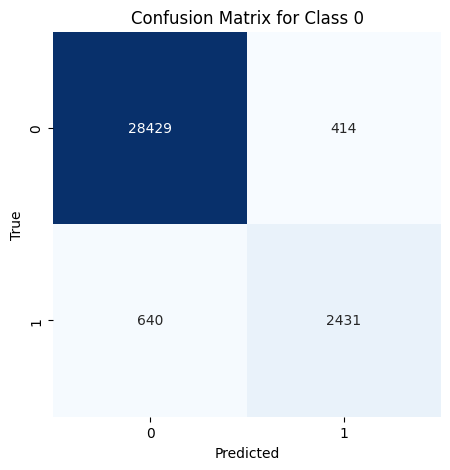

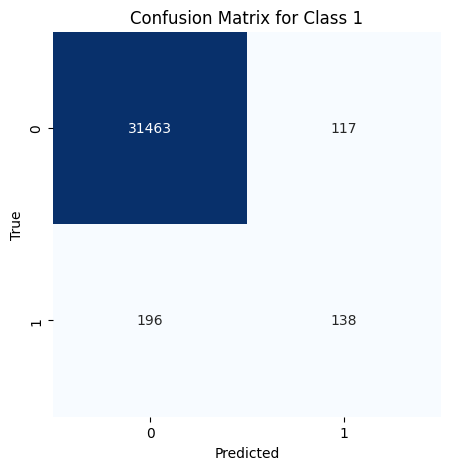

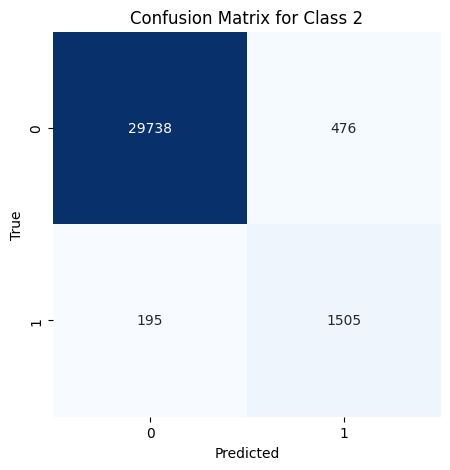

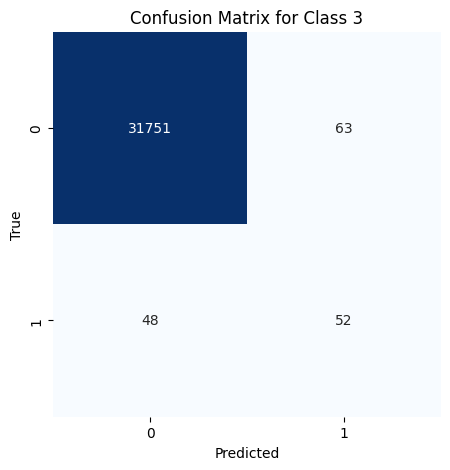

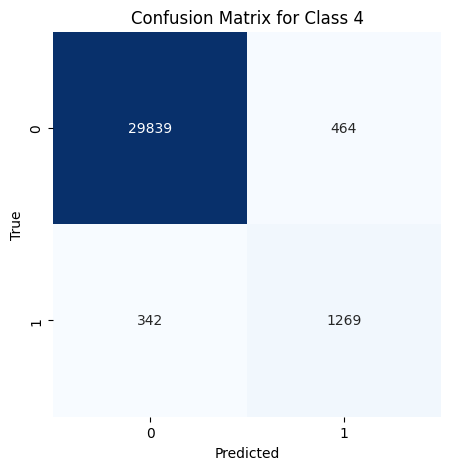

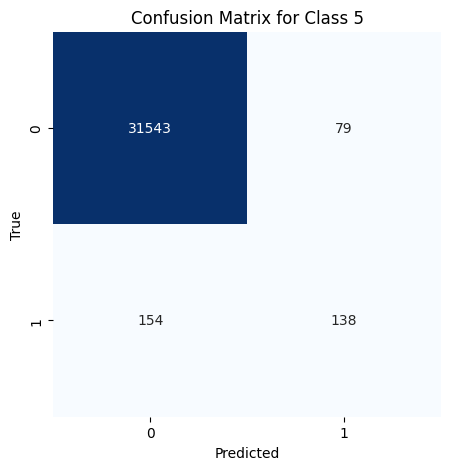

In [46]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 获取列名（排除 'comment_text'）
label_names = list(data.keys())[1:]  # 假设第一列是 'comment_text'

# 计算混淆矩阵
confusion_matrices = multilabel_confusion_matrix(targets, final_outputs)

# 可视化每个标签的混淆矩阵
for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    # 保存图像文件
    filename = f"confusion_matrix_label_class{i}.png"
    plt.savefig(filename)
    plt.close()  # 关闭当前图像，避免内存占用

In [48]:
# 保存评估结果到CSV文件
evaluation_results = pd.DataFrame({
    'Hamming Score': [hamming_loss_value],
    'Hamming Loss': [val_hamming_loss],
    'F1 Score': [f1],
    'Recall': [recall]
})

evaluation_results.to_csv('evaluation_results.csv', index=False)
print("Evaluation results saved to 'evaluation_results.csv'")

Evaluation results saved to 'evaluation_results.csv'
